#Downloading The Dataset From Kaggle

In [1]:
cd /content/

/content


In [2]:
 !pip install -q kaggle

In [ ]:
#Upload your kaggle.json file
from google.colab import files
files.upload()

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d arjuntejaswi/plant-village

100% 328M/329M [00:15<00:00, 21.0MB/s]
100% 329M/329M [00:15<00:00, 21.7MB/s]


In [ ]:
!unzip plant-village.zip -d /content/

In [9]:
import os

In [10]:
os.rename("PlantVillage", "Potato_Dataset")

In [11]:
import shutil

In [12]:
shutil.rmtree('/content/Potato_Dataset/Pepper__bell___Bacterial_spot/')
shutil.rmtree('/content/Potato_Dataset/Pepper__bell___healthy/')
shutil.rmtree('/content/Potato_Dataset/Tomato_Bacterial_spot/')
shutil.rmtree('/content/Potato_Dataset/Tomato_Early_blight/')
shutil.rmtree('/content/Potato_Dataset/Tomato_Late_blight/')
shutil.rmtree('/content/Potato_Dataset/Tomato_Leaf_Mold/')
shutil.rmtree('/content/Potato_Dataset/Tomato_Septoria_leaf_spot/')
shutil.rmtree('/content/Potato_Dataset/Tomato_Spider_mites_Two_spotted_spider_mite/')
shutil.rmtree('/content/Potato_Dataset/Tomato__Target_Spot/')
shutil.rmtree('/content/Potato_Dataset/Tomato__Tomato_YellowLeaf__Curl_Virus/')
shutil.rmtree('/content/Potato_Dataset/Tomato__Tomato_mosaic_virus/')
shutil.rmtree('/content/Potato_Dataset/Tomato_healthy/')

In [13]:
os.remove("plant-village.zip")

#Preparing The Dataset

In [14]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [15]:
image_size = 256
batch = 32
channels = 3
epochs = 50

In [16]:
#Import the dataset as a tf dataset data structure to help in preprocessing
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato_Dataset",
    shuffle = True, #to randomly shuffle the images when loading them
    image_size = (image_size, image_size),
    batch_size = batch
)

Found 2152 files belonging to 3 classes.


####"Potato__Early_blight" is class 0

In [17]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

#### - Since we specified the batch size to be 32. Therefore, we have 68 batches.

In [18]:
len(dataset)

68

In [19]:
68 * 32

2176

In [20]:
for image_batch, labels_batch in dataset.take(1): #Takes 1 batch
    print(image_batch.shape)
    print(labels_batch.numpy())
    print(image_batch[0].shape)
    print(image_batch[0].numpy())

(32, 256, 256, 3)
[1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 2 2 1 2 1 0 1 0 0 1 1 0 0]
(256, 256, 3)
[[[161. 153. 164.]
  [155. 147. 158.]
  [152. 144. 155.]
  ...
  [ 84.  72.  82.]
  [ 96.  84.  94.]
  [ 94.  82.  92.]]

 [[161. 153. 164.]
  [155. 147. 158.]
  [151. 143. 154.]
  ...
  [ 91.  79.  89.]
  [102.  90. 100.]
  [101.  89.  99.]]

 [[161. 153. 164.]
  [157. 149. 160.]
  [151. 143. 154.]
  ...
  [ 95.  83.  93.]
  [103.  91. 101.]
  [105.  93. 103.]]

 ...

 [[146. 135. 141.]
  [147. 136. 142.]
  [146. 135. 141.]
  ...
  [ 80.  65.  72.]
  [ 82.  67.  74.]
  [ 84.  69.  76.]]

 [[142. 131. 137.]
  [148. 137. 143.]
  [150. 139. 145.]
  ...
  [ 89.  74.  81.]
  [ 90.  75.  82.]
  [ 91.  76.  83.]]

 [[133. 122. 128.]
  [143. 132. 138.]
  [150. 139. 145.]
  ...
  [ 87.  72.  79.]
  [ 88.  73.  80.]
  [ 88.  73.  80.]]]


#Dataset Visualization

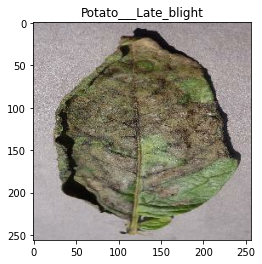

In [21]:
for image_batch, labels_batch in dataset.take(1):
  plt.title(class_name[labels_batch[0]])
  plt.imshow(image_batch[0].numpy().astype("uint8"))

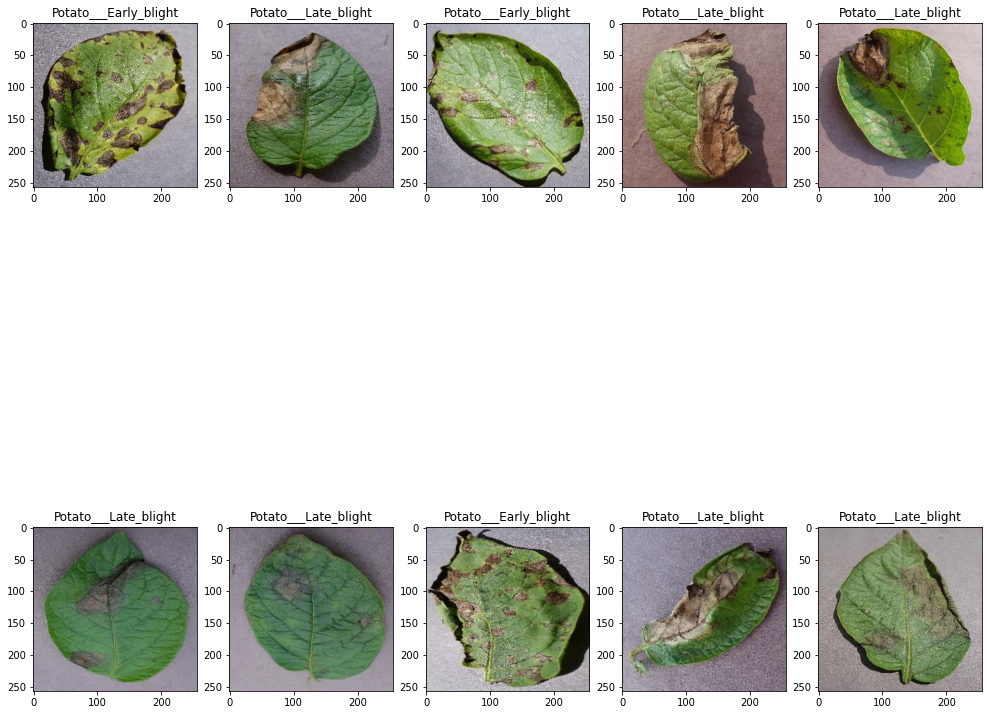

In [22]:
plt.figure(figsize = (17,17)) #To prevent images from overlapping
for image_batch, labels_batch in dataset.take(1):
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(class_name[labels_batch[i]])
    plt.imshow(image_batch[i].numpy().astype("uint8"))

#Splitting Dataset

In [23]:
len(dataset)

68

In [24]:
from typing_extensions import dataclass_transform
#We will split into 80% train, 10% validation (we will use these 10% after each epoch in the training) & 10% test (we will use these 10% after all the epochs finish)
train_split = 0.8
len(dataset) * train_split

54.400000000000006

In [25]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [26]:
test_dataset = dataset.skip(54)

In [27]:
val_split = 0.1
len(dataset) * val_split

6.800000000000001

In [28]:
val_dataset = test_dataset.take(6)
len(val_dataset)

6

In [29]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [30]:
#Let us write the above code into a function
def train_test_val_splitter(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  ds_size = len(ds)
  if(shuffle):
    ds = ds.shuffle(shuffle_size, seed = 7)
     #For perfect shuffling, set the buffer size equal to the full size of the dataset.
     #For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer.
  train_size = int(ds_size * train_split)
  val_size = int(ds_size * val_split)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [31]:
train_dataset, val_dataset, test_dataset = train_test_val_splitter(dataset)

In [32]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

54 6 8


####We will use chaching and prefetching to increase the speed
- Cahing: The first time we need an image, it will be read from the disk. The second time we need the same image, it will be read from memory. Only do this if you have enough RAM.

- Prefetching: If the GPU is busy training, we will load the next batch of images from the disk using the CPU.

In [33]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) #tf.data.AUTOTUNE lets TensorFlow determine how many batches to load while training 
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#Preprocessing The Dataset

In [34]:
resizing_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255) #To rescale an input in the [0, 255] range to be in the [0, 1] 
])

In [35]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#Building The Model

In [36]:
input_shape = (batch,image_size,image_size,channels)#The format of our input.
n_classes = len(class_name)
model = models.Sequential([
    resizing_rescaling,
    data_augmentation,
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", input_shape = input_shape), #"filters" is the number of output filters of the convolution, 32 was selected by trial and error/"kernel_size" is the size of the kernel that we are going to use to convolve with the input/"relu" is usually preferred for the hidden layers because it is fast to compute.
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(units = 64, activation = "relu"),#"units" is the number of neurons.
    layers.Dense(units = n_classes, activation = "softmax")
])

model.build(input_shape = input_shape)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [38]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]#In each epcoh, what kind of metric will we use to track the gradient descent (training process)
)

#Training The Model

In [39]:
#We will save the model training in "history" variable for plotting
history = model.fit(
    train_dataset,
    epochs = epochs,
    batch_size = batch,
    verbose = 1, #Responsible for output printing
    validation_data = val_dataset,
)

Epoch 1/50
54/54 [==============================] - 20s 146ms/step - loss: 0.8993 - accuracy: 0.4918 - val_loss: 0.9226 - val_accuracy: 0.4219
Epoch 2/50
54/54 [==============================] - 5s 91ms/step - loss: 0.8030 - accuracy: 0.6021 - val_loss: 0.7888 - val_accuracy: 0.5729
Epoch 3/50
54/54 [==============================] - 5s 91ms/step - loss: 0.6152 - accuracy: 0.7007 - val_loss: 0.5074 - val_accuracy: 0.7396
Epoch 4/50
54/54 [==============================] - 5s 91ms/step - loss: 0.4231 - accuracy: 0.8239 - val_loss: 0.3355 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 5s 100ms/step - loss: 0.3849 - accuracy: 0.8545 - val_loss: 0.3761 - val_accuracy: 0.8490
Epoch 6/50
54/54 [==============================] - 5s 92ms/step - loss: 0.3281 - accuracy: 0.8709 - val_loss: 0.2725 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 5s 91ms/step - loss: 0.2330 - accuracy: 0.9085 - val_loss: 0.1777 - val_accuracy: 0.9323
Epoch 8/50

In [40]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 2s 35ms/step - loss: 0.0643 - accuracy: 0.9688


In [41]:
scores

[0.06429335474967957, 0.96875]

#Model Analysis

In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [44]:
history.history.keys()
#We can see that the keys are: loss, accuracy, val_loss & val_accuracy, each has 50 values since we trained for 50 epochs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

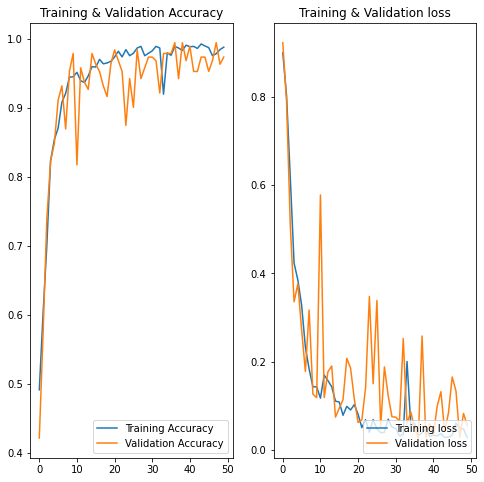

In [46]:
plt.figure(figsize = (8,8))
nrows = 1
ncols = 2
index = 1
plt.subplot(nrows, ncols, index)
plt.plot(range(epochs), accuracy, label = "Training Accuracy")
plt.plot(range(epochs), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training & Validation Accuracy")

plt.subplot(nrows, ncols, 2)
plt.plot(range(epochs), loss, label = "Training loss")
plt.plot(range(epochs), val_loss, label = "Validation loss")
plt.legend(loc = "lower right")
plt.title("Training & Validation loss")
plt.show()

#Testing The Model

In [47]:
import numpy as np

Actual label is:  Potato___Early_blight
1/1 [==============================] - 0s 135ms/step
Prediction is:  [9.9999964e-01 3.7486140e-07 9.6076434e-20]
Predicted label is:  Potato___Early_blight


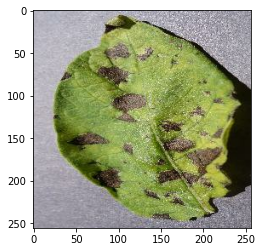

In [48]:
for image_batch, labels_batch in test_dataset.take(1):
  image = image_batch[0].numpy().astype("uint8")
  label = class_name[labels_batch[0].numpy()]
  print("Actual label is: ",label)
  plt.imshow(image)

  predicted_batch = model.predict(image_batch)
  print("Prediction is: ",predicted_batch[0])
  print("Predicted label is: ",class_name[np.argmax(predicted_batch[0])])

####Let's make a predict function

In [49]:
def predict(model, img):
  #Convert image to an array and create a batch out of it
  img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
  img_array = tf.expand_dims(img_array,0) #Shape will be (1,256,256,3)

  predictions = model.predict(img_array)
  predicted_class = class_name[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


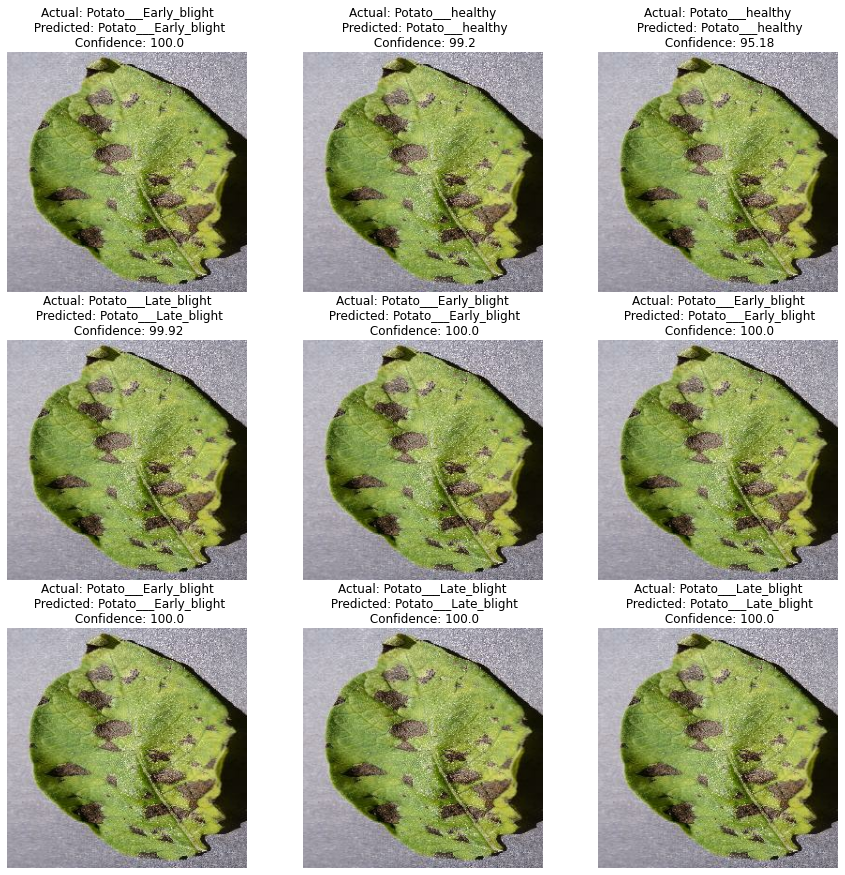

In [50]:
plt.figure(figsize = (15,15))
for image_batch, labels_batch in test_dataset.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[0].numpy().astype("uint8"))

    predicted_class, confidence = predict(model,image_batch[i])
    actual_class = class_name[labels_batch[i]]

    plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}")#Using Python's format string
    plt.axis("off")

#Saving The Model

In [51]:
!mkdir /content/Models

In [52]:
model_version = 1
model.save("/content/Models/"+str(model_version)+"")